In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# from svm_base import SelfAttn
import math
import copy
import sys
from nxt_token_solver import W_svm_solver_cvxpy, W_fin_svm_solver_cvxpy, lambda_linear_solver, Tarjan
from utils import *
sys.path.insert(1, './..')
from base import MLayerAttn
# score: Random + normalize 
# corr + sofmtax + norm 

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    # Always use the same algorithm to calculate the convolution
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
set_seed(1)


In [2]:
def normalize_sol(w):
    return w / (np.linalg.norm(w) + 1e-8)

def corr(w1, w2):
    return 1 - np.linalg.norm(normalize_sol(w1) - normalize_sol(w2))**2

def corr2(w1, w2):
    if w1.reshape(-1) @ w2.reshape(-1) == 0:
        return 0
    w1 = normalize_sol(w1)
    w2 = normalize_sol(w2)

    return w1.reshape(-1) @ w2.reshape(-1)

def corr3(w1, w2):

    w1 = normalize_sol(w1)
    w2 = normalize_sol(w2)
    return np.trace(w1 @ w2.T)


In [3]:
"""
Z = \mathbb{S}(XQK^TX^T)XV
h(X) = \langle {Zv, \mathbb{S}\bar{W}z_1} \rangle = \mathbb{S}(Z\bar{W}z_1)Zv   
where z_1 is the first token of the prompt
"""
# Useless for now
loop = False

# Numerical settings
use_double= True

# Optimization options
global_converge = False 
random_token = True

batch = True

loss_type = 'nll' # ['ce', 'nll', 'corr', 'lsq2', 'mse']
token_choice = 'random' # ['equi-corr', 'ortho', 'random']
classifier_choice = 'ortho'
# Data parameters
separa = False # Whether the last token can map to different labels
use_scc = True

rep_label = False # Whether to allow repeated labels in the sequence
rep_seq = False
toy_case = False
batch_toy = True 
custom_initialize = False 
check_label = True
check_asyc = True
same_last_token = False

# no linear head in our model
# fix_v = True # fix v or not

# Model parameters
nlayer = 1 # number of layers

skip = False # add skip connection to every attention output 
layer_norm = False # add layer norm to every attention output
avg_norm = False
factorize_w = False # use W or (Q, K)

initialize_w = 'default' # 'default': random initialization, 'zero': initialize W as zero matrix, 'random': random initialization with varying variance
initialize_wfin = 'zero'
reg_wfin = 0 # regularization for W_fin
# W_fin must be initialized as zero matrix

lr = 0.01
# output1= False
# cross_attn = True

epochs = 2
ITN = 4000

norm_grad = True

n = 4
T = 6
K = 8
# dlist = [2**i for i in range(1, 7)]
# dlist = [2, 4, 8, 32]
dlist = [8] # By setting d = T, the sequence contains all the tokens in the vocabulary without repetition

# dlist = [4, 8, 16]



# attn_probs = np.zeros((len(dlist), epochs, n, T))
# We are only interested in the final attention probs
# First T is T outputs, second T is T tokens 


corr_list = np.zeros((len(dlist), 2, epochs, ITN))
attn_probs = np.zeros((len(dlist), nlayer, epochs, ITN))
Wi_norm_list = np.zeros((nlayer, epochs, ITN))
# num_glob1 = np.zeros((len(dlist)))
num_glob = np.zeros((len(dlist)))
# run_local = []
# unsol_cnt = 0
cnt_dist = np.zeros((len(dlist), 3))


In [4]:
def search_key(dtoken, value):
    for key, val in dtoken.items():
        if (val == value).all():
            return key
    return None



def data_generator(dim_n, dim_t, dim_d, K = None, rep_label = False, rep_seq = True, choice = 'ortho', separa = True, rho = 0.5, toy = False):
    if K is None:
        K = dim_d # Setting K equals to d by default
    if choice == 'ortho':

        assert K <= dim_d 
        if separa:
            assert dim_t >= K # The sequence must constains all the tokens in the vocabulary

        A = torch.randn(dim_d, dim_d).double()

        Vocab = torch.linalg.qr(A)[0][:K] # [dim_n, K, dim_d]
    elif choice == 'equi-corr':
        A = torch.randn(dim_d, dim_d).double()
        C = torch.linalg.qr(A)[0][:K] # [dim_n, K, dim_d]
        Vocab = torch.zeros((K - 1, dim_d)).double()
        for i in range(0, K - 1):
            Vocab[i] = math.sqrt(rho) * C[0] + math.sqrt(1 - rho) * C[i + 1]

        for i in range(K - 1):
            assert Vocab[i].norm() - 1 < 1e-5
            for j in range(i + 1, K - 1):
                # Calculate the correlation between Vocab[i] and Vocab[j]
                assert torch.abs(Vocab[i].dot(Vocab[j])) - rho < 1e-5
        K = K - 1
    else:
        # assert dim_t >= K # The sequence must constains all the tokens in the vocabulary
        Vocab = torch.randn(K, dim_d).double()
        Vocab = torch.nn.functional.normalize(Vocab, dim = -1)
    dict_token = {i: Vocab[i] for i in range(K)} # used to find the index of the token
    # Generating labels 
    
    if separa:
        C = torch.multinomial(torch.ones(K).float(), K, replacement = rep_label).expand(dim_n, K) # mapping k -> \alpha_k 
        

        # For every sample in the batch, we randomly choose dim_t tokens from the vocabulary

        choice_0 = torch.multinomial(torch.ones(K).float().expand(dim_n, K), K, replacement = False)

        if dim_t == K:
            choice = choice_0
        else:
            choice_1 = torch.multinomial(torch.ones(K).float().expand(dim_n, K), dim_t - K, replacement = True)
            choice = torch.hstack([choice_0, choice_1])
        
    else:
        # first only consider the same input sequence with differnet labels
        if not toy:
            C = torch.multinomial(torch.ones(K).float().expand(dim_n, K), K, replacement = rep_label) # mapping k -> \alpha_k 
        else:
            C = torch.tensor([
                # [1, 2, 1, 3, 3],
                # [2, 2, 1, 1, 3],
                # [1, 3, 3, 0, 0],
                # [4, 0, 1, 0, 0],
                # [3, 2, 1, 0, 0],
                # [6, 2, 1, 0, 0, 0, 0],
                # [4, 2, 1, 0, 0, 0, 0],
                # [4, 2, 1, 0, 0, 0, 0],
                [1, 2, 1, 0, 0], 
                [2, 0, 1, 0, 1],
                [3, 0, 1, 0, 2],
                [4, 0, 1, 0, 0],
                [4, 0, 1, 0, 0],
                [4, 0, 1, 0, 0],
                [4, 0, 1, 0, 0],
                [4, 0, 1, 0, 0],
                [4, 0, 1, 0, 0],
                # [3, 0, 1, 2, 0],
                # [4, 0, 1, 2, 0],
                # [2, 3, 0],
            ])
            C = torch.zeros(dim_n, K).long()
            C[:, 0] = torch.arange(dim_n) + 1
            # C[0, 0 ] = 2
        assert C.shape == (dim_n, K)
        # choice_0 = torch.multinomial(torch.ones(K).float(), K, replacement = False).expand(dim_n, K)
        if dim_t <= K:
            # if rep_seq:
            #     choice_0 = torch.multinomial(torch.ones(K).float(), dim_t, replacement = False).expand(dim_n, dim_t)
            # else:
            choice_0 = torch.multinomial(torch.ones(K).float().expand(dim_n, K), dim_t, replacement = False)
            choice = choice_0
        else:
            # if rep_seq:
            #     choice_0 = torch.multinomial(torch.ones(K).float(), K, replacement = False).expand(dim_n, K)
            #     choice_1 = torch.multinomial(torch.ones(K).float(), dim_t - K, replacement = True).expand(dim_n, dim_t - K)
            # else:
            choice_0 = torch.multinomial(torch.ones(K).float().expand(dim_n, K), K, replacement = False)
            choice_1 = torch.multinomial(torch.ones(K).float().expand(dim_n, K), dim_t - K, replacement = True)
            # choice_0 = torch.multinomial(torch.ones(K).float(), K, replacement = False).expand(dim_n, dim_t)
            choice = torch.hstack([choice_0, choice_1])
        
        if rep_seq and not toy:
            # print(choice)
            print("Setting all last tokens to be 0")
            for i in range(dim_n):
                if choice[i, -1] == 0:
                    continue
                idx_zero = torch.where(choice[i] == 0)[0]
                tmp = choice[i, -1].item()
                choice[i, -1] = 0
                choice[i, idx_zero[0]] = tmp
            # print(choice)
    # assert (torch.unique(choice) == torch.arange(K).unsqueeze(0).expand(dim_n, K)).all()



    X = torch.stack([Vocab[choice[i]] for i in range(dim_n)])
    return X.double(), Vocab.double(), C, dict_token, choice.clone()

def manual_toy_case(X, Vocab, idx_token, batch = False):
    if batch:
        idx_token = [
            torch.tensor([1, 2, 0]),
            torch.tensor([2, 3, 0]),
            torch.tensor([3, 4, 0]),
            torch.tensor([4, 0]),
            # torch.tensor([4, 5, 0]),
            # torch.tensor([5, 6, 0]),
            # torch.tensor([6, 7, 0]),
            # torch.tensor([7, 8, 0]),
            # torch.tensor([8, 9, 0]),
            # torch.tensor([9, 0]),
            # [1, 2, 0],
            # [4, 0, 0],
            # [3, 2, 0]
        ]
        X = []
        for i in range(len(idx_token)):
            X.append(Vocab[idx_token[i]])
    else:
        idx_token = torch.tensor([
            [1, 2, 0],
            [1, 2, 0],
            [1, 2, 0],
            [1, 2, 0],
        ])
        X = Vocab[idx_token]
    return X, idx_token 

def cyclic_data(X, idx_token, C_alpha, scc):
    cyc_X = []
    cyc_idx = []
    for i in range(X.shape[0]):
        flag = False
        yi = idx_token[i, -1]
        for t in range(T):
            if idx_token[i,t] == C_alpha[i]:
                continue
            s1 = scc[yi][C_alpha[i]]
            s2 = scc[yi][idx_token[i, t]]
            if s1 == s2:
                flag = True
                break
        if flag:
            cyc_X.append(X[i].unsqueeze(0))
            cyc_idx.append(idx_token[i].unsqueeze(0))
        else:
            cyc_X.append([])
            cyc_idx.append([])
    

    reduced_X = []
    reduced_idx = []
    for i in range(X.shape[0]):
        if len(cyc_X[i]) == 0:
            reduced_X.append([])
            reduced_idx.append([])
            continue
        mask = torch.zeros(X.shape[1]).bool()
        yi = idx_token[i, -1]
        for t in range(T):
            s1 = scc[yi][C_alpha[i]]
            s2 = scc[yi][idx_token[i, t]]
            if s1 == s2:
                mask[t] = True
        Xi = X[i, mask].reshape(-1, X.shape[-1])
        
        reduced_X.append(Xi.unsqueeze(0))
        reduced_idx.append(idx_token[i, mask].unsqueeze(0))
    return reduced_X, reduced_idx, cyc_X, cyc_idx


In [5]:
def projecting_W(base, w):
    P = base @ np.linalg.pinv(base.T @ base) @ base.T
    return P @ w

In [6]:
# with open('wfin_zero.npy', 'rb') as f:
#     wfin_zero = np.load(f)
# proj_wfin = projecting_W(wfin_zero, wfin_zero)
# print(np.allclose(proj_wfin, wfin_zero))
# proj_wdir = projecting_W(wfin_zero, w_dir)
# print(np.allclose(np.zeros_like(w_dir), proj_wdir))

In [7]:
# for di in range(len(dlist)):
cvg_thres = 1 - 1e-6
for di in range(len(dlist)):
    print("Current d: ", dlist[di])
    d = dlist[di]
    for ei in range(epochs):
        if ei % 50 == 0:
            print("Current epoch: ", ei)
        
        flag = False
        # while (not flag):
        # Check the validity of the graph
        while (not flag):
            X, Vocab, C, dict_token, idx_token = data_generator(n, T, d, K = K, rep_label = rep_label, rep_seq = rep_seq, choice = token_choice, separa = separa, toy = toy_case)
            if same_last_token:
                for i in range(n):
                    if idx_token[i, -1] == 0:
                        continue
                    idx_zero = torch.where(idx_token[i] == 0)[0]
                    if (len(idx_zero) == 0):
                        X[i, -1] = Vocab[0]
                        idx_token[i, -1] = 0
                    else:
                        tmp = idx_token[i, -1].item()
                        idx_token[i, -1] = 0
                        idx_token[i, idx_zero[0]] = tmp
                        X[i, -1] = Vocab[0]
                        X[i, idx_zero[0]] = Vocab[tmp]
            if check_asyc:
                # print("Checking the acyclicity of the graph")
                # For simplicity we set all the samples to have the same last token
                # for i in range(n):
                #     if idx_token[i, -1] == 0:
                #         continue
                #     idx_zero = torch.where(idx_token[i] == 0)[0]
                #     if (len(idx_zero) == 0):
                #         X[i, -1] = Vocab[0]
                #         idx_token[i, -1] = 0
                #     else:
                #         tmp = idx_token[i, -1].item()
                #         idx_token[i, -1] = 0
                #         idx_token[i, idx_zero[0]] = tmp
                #         X[i, -1] = Vocab[0]
                #         X[i, idx_zero[0]] = Vocab[tmp]
                C_alpha = C[np.arange(n),idx_token[:, -1]]
                flag_asyc = True
                scc_klsti = []
                for k in range(K):
                    mask = idx_token[:, -1] == k
                    cnt = torch.sum(mask).item()
                    if cnt == 0:
                        continue
                    tarjan_solver = Tarjan(K)
                    tarjan_solver.initialize(idx_token[mask], C_alpha[mask])
                    tarjan_solver.run()
                    scc_lst = tarjan_solver.get_scc()

                    if len(set(scc_lst)) < len(scc_lst):
                        # print("Cyclic graph")
                        flag_asyc = False
                        break
                    scc_klsti.append(scc_lst)
                if not flag_asyc:
                    continue
            else:
                flag_asyc = True
            if check_label:
                flag_label = False
                # print("Checking the labels")
                cnt = 0
                for i in range(n):
                    labeli = C[i, idx_token[i, -1]]
                    flagi = False
                    for t in range(T):
                        if idx_token[i, t] == labeli:
                            flagi = True
                            break
                    if flagi == False:
                        break
                    cnt += 1
                if cnt == n:
                    flag_label = True
                # print("Each sample contains the label of the last token")
            else:
                flag_label = True

            flag = flag_label and flag_asyc
        if check_asyc:
            print("SCC: ", scc_klsti)


        # X[0, 0] = Vocab[0]
        if toy_case:
            X, idx_token = manual_toy_case(X, Vocab, idx_token, batch = batch_toy)
        print("Sample {}".format(ei))
        print("idx_token", idx_token)

        if custom_initialize:
            if ei == 0:
                const = torch.tensor(10)
            else:
                const = torch.randn(1) * 2
            alphas = [-1.5, 0, 1.5, 0.5, -0.5]
            # alphas = [-2, 2, 1, 0, -1]
            
            # alpha1 = [-4, 0, 4, 3, 2, 1,0,-1,-2,-3]
            # alpha2 = [-3, 1, 0, -1, 3,2,1,0,-1,-2]
            alphas = alphas
            init_w_toy = torch.zeros((d, d)).double()
            for i in range(len(alphas)):
                init_w_toy += Vocab[i].reshape(-1,1) @ Vocab[0].reshape(1,-1) * alphas[i]
            init_w_toy = const.double() * init_w_toy
            print("Margins should be 1, 1, 1, >1, >1")
            # print((Vocab[4] - Vocab[0]).reshape(1, -1) @ init_w_toy @ Vocab[0])
            for i in range(K - 1):
                print("{} - {} margin".format(i, i+1))
                print((Vocab[i] - Vocab[i + 1]).reshape(1, -1) @ init_w_toy @ Vocab[0].reshape( -1, 1))
        if token_choice == 'equi-corr':
            global_sol = torch.zeros((n, K - 1))
        elif token_choice == 'ortho':
            global_sol = torch.zeros((n, K))
        else:
            global_sol = torch.zeros((n, K))
            # raise NotImplementedError("Token choice {} not implemented".format(token_choice))
        

        # for i in range(n):
        #     idx_xT = search_key(dict_token, X[i, -1].squeeze())
        #     for j in range(n):
        #         idx_xj = search_key(dict_token, X[j, -1].squeeze())
        #         if idx_xj == idx_xT:
        #             k = C[j, idx_xj]
        #             global_sol[i, k] += 1
        #             continue

        #     global_sol[i] /= global_sol[i].sum()
        #     # if (global_sol.max(axis = -1)[0] < 1).any():
        #     #     flag = True # Must generate same tokens with different labels

        model = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                        identity_W=False, identity_V = True, 
                        factorize_W = factorize_w, init = initialize_w,
                        skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
                )
        # print(model.qklist[0].weight)
        # Copy one model to Wfin
        # if strong_default:
        #     model_fin = copy.deepcopy(model)
        # print("Covariance of the weight matrix on initialization: ", torch.cov(model.qklist[0].weight))
        if not custom_initialize:
            print("Using {} initialization".format(initialize_w))
            print("Variance of the weight matrix on initialization: ", torch.var(model.qklist[0].weight))
        model = model.double()
            
        # Parameter Initialization 
        if factorize_w:
            parameter_list = [model.query1.weight, model.query2.weight, model.key1.weight, model.key2.weight]
        else:
            parameter_list = [m.weight for m in model.qklist]
        
        if layer_norm and not avg_norm:
            parameter_list += [model.ln.weight, model.ln.bias]
        if custom_initialize:
            print("Initialize w manually")
            model.qklist[0].weight.data = init_w_toy
            print("Norm of w on initialization: ", init_w_toy.norm())
        optimizer = torch.optim.SGD(parameter_list, lr=lr, )
        Wi_list = np.zeros((nlayer, ITN, d, d))
        Wfini_list = np.zeros((nlayer, ITN, d, d))
        sol_cvx_list = np.zeros((nlayer, 3, d, d))
        if toy_case and batch_toy:
            z = []
            for i in range(len(X)):
                zi = X[i][-1]
                z.append(zi)
            z = torch.stack(z)
            assert z.shape == (n, d)
        else:
            z = X[:, -1].unsqueeze(1) # [n, d]
        idx_z = []
        
        for i in range(n):
            idx_zi = search_key(dict_token, z[i].squeeze())
            idx_z.append(idx_zi)
        idx_z = torch.tensor(idx_z)

        C_alpha = C[np.arange(n),idx_z]
        print("C_alpha", C_alpha)
        if loss_type == 'nll':
            nll = torch.nn.NLLLoss()
        elif loss_type == 'ce':
            ce = torch.nn.CrossEntropyLoss()
        for it in range(ITN):
            
            if toy_case and batch_toy:
                loss = torch.zeros(1)
                for i in range(len(X)):
                    ni = 1
                    out = model(X[i].unsqueeze(0), z[i].unsqueeze(0))
                    mask = torch.nn.functional.one_hot(idx_token[i].unsqueeze(0), num_classes=K).float().permute(0, 2, 1).double()
                    hat_y = (mask @ model.attn[0].permute(0, 2, 1)).squeeze(-1) # [n, K]
                    if loss_type == 'mse':
                        pred = hat_y @ Vocab
                        target = Vocab[C_alpha[i]].unsqueeze(0)
                        loss_mse = torch.nn.MSELoss(reduction = 'sum')
                        loss += loss_mse(pred, target)
                    elif loss_type == 'lsq2':
                        # loss += (1 - hat_y.squeeze()[C_alpha[i]])**2
                        loss += (1 - Vocab[C_alpha[i]].reshape(1, -1) @ X[i].squeeze().T @ model.attn[0].squeeze())**2
                    elif loss_type == 'nll':
                        loss += nll(torch.log(hat_y + 1e-10), C_alpha[i].unsqueeze(0))
                        # loss += nll(torch.log(hat_y), C_alpha[i].unsqueeze(0))
                    elif loss_type == 'ce':
                        loss += ce(torch.log(hat_y + 1e-10), C_alpha[i].unsqueeze(0))
                        # loss += ce(torch.log(hat_y), C_alpha[i].unsqueeze(0))
                    elif loss_type == 'corr':
                        raise NotImplementedError("Not implemented")
                loss = loss /len(X)

            else:
                out = model(X, z)
                if token_choice == 'ortho':
                    hat_y = (Vocab @ out.squeeze().reshape(n, -1, 1)).squeeze(-1) # [n, K]
                else:
                    mask = torch.nn.functional.one_hot(idx_token, num_classes=K).float().permute(0, 2, 1).double()
                    hat_y = (mask @ model.attn[0].permute(0, 2, 1)).squeeze(-1) # [n, K]
                
                if loss_type == 'lsq2':
                    target_out = Vocab[C_alpha].unsqueeze(1)
                    assert out.shape == target_out.shape
                    loss = (target_out - out)**2
                elif loss_type == 'corr':
                    # assert out.shape == Y.shape
                    # loss = -(Y @ out.permute(0, 2, 1))
                    Y = torch.nn.functional.one_hot(C_alpha, num_classes = K).double().unsqueeze(1) 
                    # print(Y.shape, hat_y.shape)
                    loss = - Y @ hat_y.unsqueeze(-1)
                    # loss_lsq = (Y - out)**2
                    # loss_lsq = loss_lsq.mean()
                elif loss_type == 'nll':
                    # loss1 = nll(torch.log(t_attn), C_alpha)
                    eps = torch.finfo(hat_y.dtype).eps
                    loss = nll(torch.log(hat_y + eps), C_alpha)
                elif loss_type == 'ce':
                    eps = torch.finfo(hat_y.dtype).eps
                    loss = ce(torch.log(hat_y + eps), C_alpha)
                else:
                    raise NotImplementedError("Loss type {} not implemented".format(loss_type))
                # loss += reg_lambda * sum(torch.linalg.norm(p, 2) for p in parameter_list)
                # print("Current iteration: {}, Loss: {:.4f}".format(it, loss))
                loss = loss.mean()
                if np.isnan(loss.item()):
                    print("Nan loss")
                    raise ValueError("Nan loss")
            optimizer.zero_grad()
            # with torch.autograd.detect_anomaly(False):
                # print(loss)
            loss.backward()
            pi = 0
            for p in parameter_list:
                # print("Norm of grad: ", p.grad.norm()) 
                if norm_grad:
                    p.grad /= (p.grad.norm()+torch.finfo(p.data.dtype).eps)
                    # p.grad /= (p.grad.norm()+1e-10)
                if it % 500 == 0:
                    print("Norm of grad: ", p.grad.norm())
                    # print(p.grad)
                pi += 1
            optimizer.step()  
            if it % 500 == 0:
                print("Current iteration: {}, Loss: {:.4f}".format(it, loss.item()))
                # print(torch.linalg.norm(model.qklist[0].weight))
            for ni in range(nlayer):
                sol_gd = np.copy(model.qklist[ni].weight.detach().numpy())
                Wi_norm_list[ni, ei, it] = np.linalg.norm(sol_gd)
                # sol_gd /= np.linalg.norm(sol_gd)
                Wi_list[ni, it] = sol_gd
                try:
                    with open('wfin_zero_10.npy', 'rb') as f:
                        wfin_zero = np.load(f)
                    proj_w = projecting_W(wfin_zero,sol_gd)
                    
                    if it % 500 == 0:
                        pass
                        # print("Unnormalized Correlation between Proj_Sfin(W) and Wfin: {:.4f}".format(proj_w.reshape(-1).dot(wfin_zero.reshape(-1))))
                        # print("Normalized Correlation between Proj_Sfin(W) and Wfin: {:.4f}".format(corr2(proj_w, wfin_zero)))
                        # print("normalized Norm difference: {:.4f}".format(np.linalg.norm(normalize_sol(proj_w) - normalize_sol(wfin_zero))))
                        # print("norm of difference: {:.4f}".format(np.linalg.norm(proj_w - wfin_zero)))
                        # print("R2 error: {}".format(np.linalg.norm(proj_w - wfin_zero)**2 / np.linalg.norm(wfin_zero)**2))
                except:
                    pass
                    
                sfx_out = model.attn[ni].detach().max(dim = -1)
                attn_probs[di, ni, ei, it] = sfx_out[0].mean()
        
        cnt_dist = collect_converg(separa, model, cvg_thres, cnt_dist, search_key, dict_token, X, di, C_alpha, loss_type)
        
        if not toy_case and not use_scc:
            print("Solving the SVM problem using one token constraint")
            w_onetoken = W_svm_solver_cvxpy(Vocab, n, T, d, idx_z, C, onetoken = True, global_sol = hat_y.squeeze().detach().numpy())
            
            sol_cvx_one = normalize_sol(w_onetoken)

            if not separa:
                # try:
                print("Solving the SVM problem using all constriants")
                w_dir, w_svm = W_svm_solver_cvxpy(Vocab, n, T, d, idx_z, C, onetoken = False, wfin = True, global_sol = hat_y.squeeze().detach().numpy(), W_grad = Wi_list[0, -1]) 
                # print("Corre: ", corr2(w1, w2))
                sol_cvx1 = normalize_sol(w_dir)
                sol_cvx2 = normalize_sol(w_svm)

                
            sol_cvx_list[0, 0] = sol_cvx_one
            if not separa:
                sol_cvx_list[0, 1] = sol_cvx1
                sol_cvx_list[0, 2] = sol_cvx2
 
            # if not (global_converge and (not np.all(tmp == n))):
        elif use_scc:
            # Requires that the last token is the same for all the samples
            # assert (idx_token[:, -1] == idx_token[0, -1]).all()
            if token_choice == 'equi-corr':
                adj_mat = np.zeros((K -1, K - 1, K -1)) # #of distinct last tokens, |ID|, |ID|
            else:
                adj_mat = np.zeros((K , K , K )) # #of distinct last tokens, |ID|, |ID|
            for i in range(len(idx_token)):
                for j in range(len(idx_token[i])):
                    if C_alpha[i] == idx_token[i][j]:
                        continue
                    adj_mat[idx_token[i][-1], C_alpha[i], idx_token[i][j]] = 1
            print("Solving the SVM problem using mm constriants")
            scc_klst = []
            if toy_case:
                assert len(set(idx_z)) == len(idx_z), "for toy case we only assuem the same last token"
                for k in range(K):
                    if idx_z[0] == k:
                        tarjan_solver = Tarjan(K)
                        tarjan_solver.initialize(idx_token, C_alpha)
                        tarjan_solver.run()
                        scc_lst = tarjan_solver.get_scc()
                        scc_klst.append(scc_lst)
                    else:
                        scc_klst.append([])
            else:
                for k in range(K):
                    tarjan_solver = Tarjan(K)
                    mask = idx_token[:, -1] == k
                    cnt = torch.sum(mask).item()
                    if cnt == 0:
                        scc_klst.append([])
                        continue
                    tarjan_solver.initialize(idx_token[mask], C_alpha[mask])
                    tarjan_solver.run()
                    scc_lst = tarjan_solver.get_scc()
                    scc_klst.append(scc_lst)

            w_dir = W_svm_solver_cvxpy(Vocab, n, T, d, idx_z, C, onetoken = False, wfin = False, adj_mat = adj_mat,  W_grad = Wi_list[0, -1], scc_lst = scc_klst) 
            if toy_case:
                if toy_case:
                    adj_mat_toy = np.copy(adj_mat)
                    # adj_mat_toy[0][1][2] = 0
                    # adj_mat_toy[0][1][0] = 0 
                    # adj_mat_toy[0][2][1] = 1
                    # adj_mat_toy[0][2][1] = 0
                    # adj_mat_toy[0][1][0] = 1
                    # adj_mat_toy[0][1][2] = 1

                    w_dir_toy = W_svm_solver_cvxpy(Vocab, n, T, d, idx_z, C, onetoken = False, wfin = False, adj_mat = adj_mat_toy,  W_grad = Wi_list[0, -1], scc_lst = scc_klst) 

            sol_cvx1 = normalize_sol(w_dir)
            sol_cvx_list[0, 1] = sol_cvx1
            # Calculating W_fin 
            if np.isclose(w_dir, np.zeros((d, d))).all():
                corr_list[di, 0, ei, :] = np.nan
            if toy_case: 
                continue
            red_X, red_idx_token, cyc_X, cyc_idx_token = cyclic_data(X, idx_token, C_alpha, scc_klst)
            # red_z = []
            # for i in range(len(red_X)):
            #     red_z.append(red_X[i][:, -1])
            # red_z = torch.cat(red_z, dim = 0).unsqueeze(1)

            model_fin = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                            identity_W=False, identity_V = True, 
                            factorize_W = factorize_w, init = initialize_wfin,
                            skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
                    ).double()
            # print(model_fin.qklist[0].weight)
            # Parameter Initialization 
            parameter_list = [m.weight for m in model_fin.qklist]
        
            optimizer = torch.optim.SGD(parameter_list, lr=lr, )

            for it in range(ITN):
                loss = torch.zeros(1)
                for i in range(len(red_X)):
                    ni = 1
                    if len(red_X[i]) == 0:
                        continue
                    # if remove_sing:
                    #     if (np.unique(red_idx_token[i]) == C_alpha[i].detach().numpy()).all():
                    #         if it == 0:
                    #             print("Skipping: ", red_idx_token[i])
                    #         continue
                    out = model_fin(red_X[i], z[i])
                    # hat_y = (Vocab @ out.squeeze().reshape(ni, -1, 1)).squeeze(-1) # [n, K]
                    if token_choice == 'ortho':
                        hat_y = (Vocab @ out.squeeze().reshape(ni, -1, 1)).squeeze(-1) # [n, K]
                    else:
                        mask = torch.nn.functional.one_hot(red_idx_token[i], num_classes=K).float().permute(0, 2, 1).double()
                        hat_y = (mask @ model_fin.attn[0].permute(0, 2, 1)).squeeze(-1)
                    if loss_type == 'lsq2':
                        target_out = Vocab[C_alpha[i]].unsqueeze(1)
                        assert out.shape == target_out.shape
                        loss += (target_out - out)**2
                    elif loss_type == 'corr':
                        # assert out.shape == Y.shape
                        # loss = -(Y @ out.permute(0, 2, 1))
                        Y = torch.nn.functional.one_hot(C_alpha[i], num_classes = K).double().reshape(1, 1, -1)
                        loss += (- Y @ hat_y.reshape(1, -1, 1)).squeeze()
                        # loss_lsq = (Y - out)**2
                        # loss_lsq = loss_lsq.mean()
                    elif loss_type == 'nll':
                        # loss1 = nll(torch.log(t_attn), C_alpha)
                        eps = torch.finfo(hat_y.dtype).eps
                        # loss += nll(torch.log(hat_y + eps), C_alpha)
                        loss += nll(torch.log(hat_y + eps), C_alpha[i].unsqueeze(0))
                    elif loss_type == 'ce':
                        eps = torch.finfo(hat_y.dtype).eps
                        loss += ce(torch.log(hat_y + eps), C_alpha[i].unsqueeze(0))
                    else:
                        raise NotImplementedError("Loss type {} not implemented".format(loss_type))
                    # loss += reg_lambda * sum(torch.linalg.norm(p, 2) for p in parameter_list)
                    # print("Current iteration: {}, Loss: {:.4f}".format(it, loss))
                    # loss = loss.mean()
                loss = loss / n
                if it % 500 == 0:
                    print("Training W_fin Current iteration: {}, raw Loss: {:.4f}".format(it, loss.item()))
                loss += reg_wfin * (model_fin.qklist[0].weight.norm()**2)
                if it % 500 == 0:
                    print("Training W_fin Current iteration: {}, Loss: {:.4f}".format(it, loss.item()))
                optimizer.zero_grad()
                loss.backward()
                
                pi = 0
                for p in parameter_list:
                    
                    if norm_grad:
                        p.grad /= (p.grad.norm()+torch.finfo(p.data.dtype).eps)
                        # p.grad /= (p.grad.norm()+1e-10)

                    pi += 1
                optimizer.step()
                for ni in range(nlayer):
                    sol_gd = np.copy(model_fin.qklist[ni].weight.detach().numpy())
                    Wfini_list[ni, it] = sol_gd 
            print("Correlation between W_fin and W_svm: {:.4f}".format(corr2(Wfini_list[0, -1], w_dir)))
        # Optimizing R 
        if use_scc and not toy_case:
            import cvxpy as cp
            R = cp.Variable(1)
            prob_R = cp.Problem(cp.Minimize(cp.norm(Wfini_list[0, -1] + R * w_dir - Wi_list[0, -1], 'fro')))
            prob_R.solve()
            R = R.value
            # sol_cvx_list[0, 2] = normalize_sol(Wfini_list[0, -1] + R * w_dir)
        if not toy_case:
            for it in range(ITN):
                Wi_list[0, it] /= np.linalg.norm(Wi_list[0, it])
                # corr_list[di, 0, ei, it] = Wi_list[0, it].reshape(-1).dot(sol_cvx_list[0, 0].reshape(-1))
                if not separa:
                    if corr_list[di, 0, ei, it] == 0:
                        corr_list[di, 0, ei, it] = Wi_list[0, it].reshape(-1).dot(sol_cvx_list[0, 1].reshape(-1))
                    corr_list[di, 1, ei, it] = Wi_list[0, it].reshape(-1).dot(normalize_sol(Wfini_list[0, -1] + R * w_dir).reshape(-1))
                # if it % 100 == 0:
                #     print("Iters {}, Correlation between Wmm and W: {:.4f}".format(it, corr2(Wi_list[0, it], w_dir)))
                if it == ITN - 1 and corr_list[di, :, ei, it].max() < 0.9:
                    print("Correlation is too low")
                    print(corr_list[di, :, ei, it].max())
                    print("X: ", X)
                    # print("t_attn: ", t_attn)
                    print("hat_y", hat_y)
                    # print("Global_sol", global_sol)
                    
                    # print("Y: ", Y)
                    # print("out: ", out)
                    # raise Exception("Correlation is too low")
            print("Correlation of W and Wsvm", corr_list[di, 0, ei, -1])
            print(scc_klst)
    num_glob[di] = num_glob[di] / (epochs)

# print("Number of unsolved sols:", unsol_cnt)

Current d:  8
Current epoch:  0
SCC:  [[0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 6, 7, 3, 5, 4], [0, 1, 2, 3, 7, 5, 4, 6]]
Sample 0
idx_token tensor([[6, 7, 5, 3, 2, 1],
        [0, 4, 7, 1, 5, 3],
        [3, 4, 7, 1, 5, 6],
        [3, 0, 6, 1, 7, 5]])
Using default initialization
Variance of the weight matrix on initialization:  tensor(0.0395, grad_fn=<VarBackward0>)
C_alpha tensor([7, 7, 4, 3])
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 0, Loss: 1.8428
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 500, Loss: 0.4809
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 1000, Loss: 0.1021
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 1500, Loss: 0.0192
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 2000, Loss: 0.0035
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 2500, Loss: 0.0007
Norm of grad:  tensor(1.0000, dtype=torch.float6

In [8]:
print("Option 2 (joint) {}".format('with skip connection' if skip else ' '))
# print("Input: ", X)
print("Number of layers: ", nlayer)

print("Iterations: ", ITN)
print("Learning rate", lr)
# print("W: ", model.qk1.weight)
# print("Wbar: ", model.qk2.weight)

for i in range(len(model.qklist)):
    print("Attn of layer {}: ".format(i), model.attn[i])
    print("Attn of layer {}: ".format(i), model_fin.attn[i])
    print("Out of layer {}: ".format(i), model.out[i])
    # print("Weight of layer {}: ".format(i), model.qklist[i].weight)

# print("Global loss: ", global_loss)
for i in range(len(model.qklist)):
    print("Norm of layer {}: ".format(i), torch.norm(model.qklist[i].weight))


cnt_dist[di] /= epochs

Option 2 (joint)  
Number of layers:  1
Iterations:  4000
Learning rate 0.01
Attn of layer 0:  tensor([[[1.0000e+00, 1.3821e-06, 1.5257e-08, 3.4304e-07, 9.0953e-09,
          2.5448e-10]],

        [[4.2165e-07, 1.0771e-06, 1.3320e-06, 5.0403e-06, 9.9999e-01,
          1.3788e-07]],

        [[3.7096e-06, 4.7371e-07, 1.3633e-06, 7.6845e-07, 9.9999e-01,
          7.1046e-10]],

        [[2.3794e-12, 6.8477e-12, 5.0229e-06, 9.9999e-01, 5.0047e-12,
          3.5685e-15]]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)
Attn of layer 0:  []
Out of layer 0:  tensor([[[ 0.7738,  0.4254,  0.2732, -0.1979, -0.1072,  0.2638,  0.0348,
           0.1556]],

        [[-0.1842, -0.1343,  0.1233,  0.3264,  0.0019,  0.2562, -0.2186,
          -0.8443]],

        [[-0.2630,  0.6259, -0.0360,  0.6697, -0.1290, -0.2345, -0.0075,
           0.1330]],

        [[ 0.7738,  0.4254,  0.2732, -0.1979, -0.1072,  0.2638,  0.0348,
           0.1556]]], dtype=torch.float64, grad_fn=<UnsafeViewBackward0>)
Norm o

In [9]:
print("idx token: ", idx_token)
print("cyc idx token: ", cyc_idx_token)
print("cyc_bar idx token: ", red_idx_token)
print("Target of each sequence: ", C_alpha)
print("Hat_y: ", hat_y.squeeze())
# print("Adj matrix: ", adj_mat.squeeze())

idx token:  tensor([[0, 2, 3, 7, 4, 5],
        [1, 7, 6, 3, 2, 4],
        [1, 3, 2, 5, 6, 7],
        [3, 2, 6, 0, 4, 7]])
cyc idx token:  [[], [], [], []]
cyc_bar idx token:  [[], [], [], []]
Target of each sequence:  tensor([0, 2, 6, 0])
Hat_y:  tensor([[1.0000e+00, 0.0000e+00, 1.3821e-06, 1.5257e-08, 9.0953e-09, 2.5448e-10,
         0.0000e+00, 3.4304e-07],
        [0.0000e+00, 4.2165e-07, 9.9999e-01, 5.0403e-06, 1.3788e-07, 0.0000e+00,
         1.3320e-06, 1.0771e-06],
        [0.0000e+00, 3.7096e-06, 1.3633e-06, 4.7371e-07, 0.0000e+00, 7.6845e-07,
         9.9999e-01, 7.1046e-10],
        [9.9999e-01, 0.0000e+00, 6.8477e-12, 2.3794e-12, 5.0047e-12, 0.0000e+00,
         5.0229e-06, 3.5685e-15]], dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)


In [10]:
# tarjan_solver = Tarjan(K)
# tarjan_solver.initialize(idx_token, C_alpha)
# tarjan_solver.run()
# tarjan_solver.output()
# print("Scc list: ", scc_klst)

Number of SCC:  7
SCC 0 : 
7 
size:  1

SCC 1 : 
4 
size:  1

SCC 2 : 
5 
size:  1

SCC 3 : 
3 
size:  1

SCC 4 : 
1 
size:  1

SCC 5 : 
2 6 
size:  2

SCC 6 : 
0 
size:  1

Scc list:  [[], [], [], [], [0, 1, 6, 3, 2, 7, 4, 5], [5, 6, 4, 3, 1, 0, 7, 2], [], [7, 5, 3, 4, 1, 2, 6, 0]]


In [11]:
# x = []

# x0  = torch.zeros(1, 3, d).double()
# x0[0, 0] = Vocab[1]
# x0[0, 1] = Vocab[2]
# x0[0, -1] = Vocab[0]
# # x0[0, 3] = Vocab[1]
# x.append(x0)

# original_W = model.qklist[0].weight.data.clone()

# for xi in x:
#     print(xi)

#     out = model(xi, xi[0,-1])
#     hat_y = Vocab @ out.squeeze().reshape(1, -1, 1)
#     print(hat_y)
    

In [12]:
print("Correlation")
for ii in range(corr_list.shape[1]):
    print(corr_list[0, ii, :, -1])

Correlation
[0.99106015 0.99460149]
[0.99106016 0.99460149]


0.992830820988184


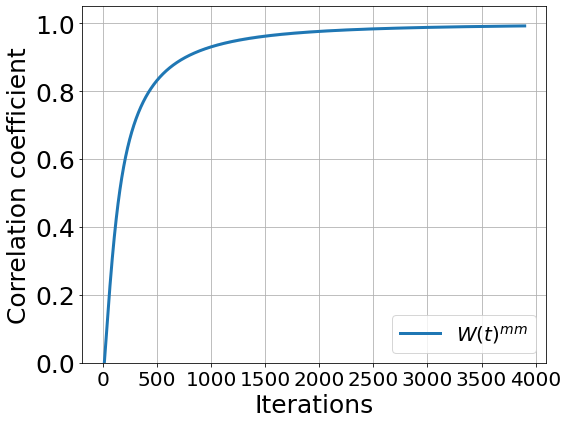

In [16]:
# set idx=0 for W-parametrization
# set idx=1 for (K, Q)-parametrization
idx = 0

plt.figure(figsize=(8,6))
THRED = ITN - 100
alt_corr_list = corr_list
labels = [
    # r'$W(t)^{onetoken}$', 
    r'$W(t)^{mm}$', 
    r'$W(t)$', 
]
# if skip:
#     alt_corr_list = corr_list[corr_list[:, :, -1] > 1e-6].reshape(nlayer, -1, ITN)
# else:
#     alt_corr_list = corr_list[0][corr_list[0, :, -1] > 1e-6].reshape(1, -1, ITN)
# # if global_converge:
# #     assert alt_corr_list.shape[1] == num_glob2 * epochs

for idx in range(len(dlist)):
    # if (alt_corr_list[idx, 0, :, :THRED] == np.nan).sum() > 0:
    #         print("Setting to zero")
    #         alt_corr_list[idx, 0, :, :THRED] = 0
    for ii in range(corr_list.shape[1]):
        print(np.mean(alt_corr_list[idx, ii], axis = 0)[-1])
        plt.plot(np.mean(alt_corr_list[idx, ii], axis = 0)[:THRED], linewidth=3, label=labels[ii])
        mean, std = np.mean(alt_corr_list[idx, ii], axis = 0)[:THRED], np.std(alt_corr_list[idx, ii], axis = 0)[:THRED]
        # print(mean[-1], std[-1])
        plt.fill_between(range(THRED), mean-std, mean+std, alpha=0.15, linewidth=0)
        # if separa:
        break
    plt.legend(fontsize=20, loc = 'lower right')
    plt.xlabel('Iterations', fontsize=25)
    plt.ylabel('Correlation coefficient', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=25)
    plt.ylim([0, 1.05])
plt.grid()
plt.tight_layout()
plt.show()

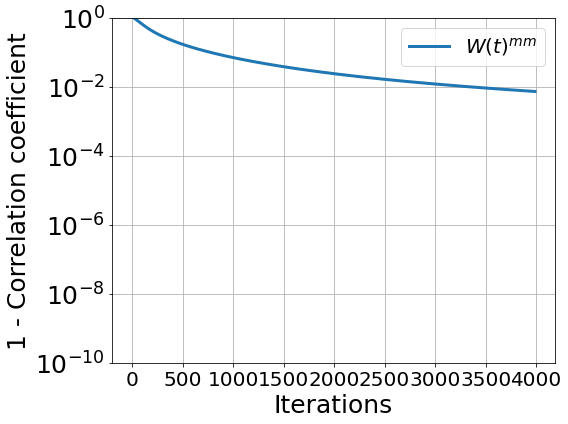

In [14]:
# set idx=0 for W-parametrization
# set idx=1 for (K, Q)-parametrization
idx = 0

plt.figure(figsize=(8,6))
THRED = ITN - 10
alt_corr_list = corr_list
labels = [
    # r'$W(t)^{onetoken}$', 
    r'$W(t)^{mm}$', 
    r'$W(t)$', 
]
# if skip:
#     alt_corr_list = corr_list[corr_list[:, :, -1] > 1e-6].reshape(nlayer, -1, ITN)
# else:
#     alt_corr_list = corr_list[0][corr_list[0, :, -1] > 1e-6].reshape(1, -1, ITN)
# # if global_converge:
# #     assert alt_corr_list.shape[1] == num_glob2 * epochs
for idx in range(len(dlist)):
    for ii in range(corr_list.shape[1]):
        plt.plot(1 - np.nanmean(alt_corr_list[idx, ii], axis = 0)[:THRED], linewidth=3, label=labels[ii])
        # plt.plot((1 - alt_corr_list[idx, ii]).mean(0)[:THRED], linewidth=3, label=labels[ii])
        # if separa:
        break
    plt.legend(fontsize=20)
    plt.yscale('log')
    plt.xlabel('Iterations', fontsize=25)
    plt.ylabel('1 - Correlation coefficient', fontsize=25)
    plt.ylim([1e-10, 1])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=25)
    # plt.ylim([0, 1.05])
plt.grid()
plt.tight_layout()
plt.show()

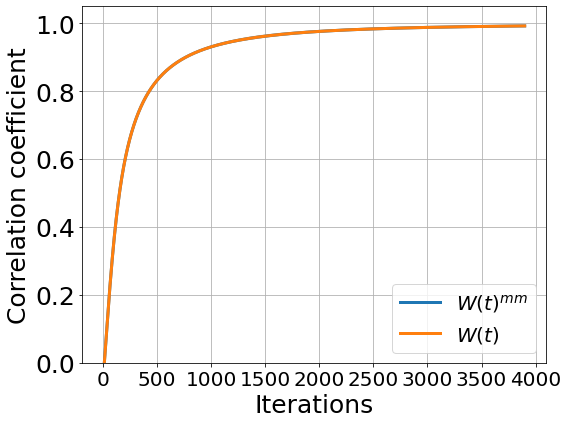

In [17]:
# set idx=0 for W-parametrization
# set idx=1 for (K, Q)-parametrization
idx = 0

plt.figure(figsize=(8,6))
THRED = ITN - 100
alt_corr_list = corr_list
labels = [
    # r'$W(t)^{onetoken}$', 
    r'$W(t)^{mm}$', 
    r'$W(t)$', 
]
# if skip:
#     alt_corr_list = corr_list[corr_list[:, :, -1] > 1e-6].reshape(nlayer, -1, ITN)
# else:
#     alt_corr_list = corr_list[0][corr_list[0, :, -1] > 1e-6].reshape(1, -1, ITN)
# # if global_converge:
# #     assert alt_corr_list.shape[1] == num_glob2 * epochs

for idx in range(len(dlist)):
    # if (alt_corr_list[idx, 0, :, :THRED] == np.nan).sum() > 0:
    #         print("Setting to zero")
    #         alt_corr_list[idx, 0, :, :THRED] = 0
    for ii in range(corr_list.shape[1]):
        # print(np.mean(alt_corr_list[idx, ii], axis = 0)[-1])
        plt.plot(np.mean(alt_corr_list[idx, ii], axis = 0)[:THRED], linewidth=3, label=labels[ii])
        mean, std = np.mean(alt_corr_list[idx, ii], axis = 0)[:THRED], np.std(alt_corr_list[idx, ii], axis = 0)[:THRED]
        # print(mean[-1], std[-1])
        plt.fill_between(range(THRED), mean-std, mean+std, alpha=0.15, linewidth=0)
        # if separa:
        #     break
    plt.legend(fontsize=20, loc = 'lower right')
    plt.xlabel('Iterations', fontsize=25)
    plt.ylabel('Correlation coefficient', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=25)
    plt.ylim([0, 1.05])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# set idx=0 for W-parametrization
# set idx=1 for (K, Q)-parametrization
idx = 0

plt.figure(figsize=(8,6))
THRED = ITN - 10
alt_corr_list = corr_list
labels = [
    # r'$W(t)^{onetoken}$', 
    r'$W(t)^{mm}$', 
    r'$W(t)$', 
]
# if skip:
#     alt_corr_list = corr_list[corr_list[:, :, -1] > 1e-6].reshape(nlayer, -1, ITN)
# else:
#     alt_corr_list = corr_list[0][corr_list[0, :, -1] > 1e-6].reshape(1, -1, ITN)
# # if global_converge:
# #     assert alt_corr_list.shape[1] == num_glob2 * epochs
for idx in range(len(dlist)):
    for ii in range(corr_list.shape[1]):
        plt.plot(1 - np.nanmean(alt_corr_list[idx, ii], axis = 0)[:THRED], linewidth=3, label=labels[ii])
        # plt.plot((1 - alt_corr_list[idx, ii]).mean(0)[:THRED], linewidth=3, label=labels[ii])
        if separa:
            break
    plt.legend(fontsize=20)
    plt.yscale('log')
    plt.xlabel('Iterations', fontsize=25)
    plt.ylabel('1 - Correlation coefficient', fontsize=25)
    plt.ylim([1e-10, 1])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=25)
    # plt.ylim([0, 1.05])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# wfini = Wfini_list[0, -1]
# proj_W1 = wfini.T @ np.linalg.inv(wfini @ wfini.T) @ wfini @ model.qklist[0].weight.detach().numpy()
# proj_W2 = wfini @ np.linalg.inv(wfini.T @ wfini) @ wfini.T @ model.qklist[0].weight.detach().numpy()
# # print(corr2(proj_W1, wfini))
# # print(corr2(proj_W2, wfini))


In [ ]:

fig = plt.figure(figsize =(8, 6))
labels = [
    r'$\mathrm{\mathbb{S}}(XW(t)_{\alpha}Z_i) < 1$', 
    r'$W(t) \to W^{mm}$', 
    r'$W(t) \to W^{mm*}$', 
    # r'$W(t) \to W^{lmm}$', 
    # r'averaged distribution',
]

x = np.arange(len(dlist))  # the label locations

# for ni in range(len(nlayer_lst)):
# nlayer = nlayer_lst[ni]
# for ri in range(len(model.qklist)):
# ri = 0 # Only consider the first layer
width = 0.8 / cnt_dist.shape[-1]
multiplier = 0

for i in range(cnt_dist.shape[-1]):
    offset = width * multiplier
    rects = plt.bar(x + offset, cnt_dist[0, i], width, label=labels[i])
    multiplier += 1

plt.xticks(x + width, dlist)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.grid(axis = 'y', linestyle = '--')

fig.supxlabel('d', fontsize = 20)
fig.supylabel('Probabilities', fontsize = 20)

plt.legend(loc=(-0.6, 0.8), fontsize = 15)

# ax.set_ylim(0, 250)

In [ ]:
# set idx=0 for W-parametrization
# set idx=1 for (K, Q)-parametrization
idx = 0

plt.figure(figsize=(8,6))
THRED = ITN - 10

for idx in range(nlayer):
    plt.plot(Wi_norm_list[idx].mean(0)[:THRED], linewidth=3, label=r'$W_{}$'.format(idx+1))
    mean, std = Wi_norm_list[idx].mean(0)[:THRED], Wi_norm_list[idx].std(0)[:THRED]
    plt.fill_between(range(THRED), mean-std, mean+std, alpha=0.15, linewidth=0)
    plt.legend(fontsize=30)
    plt.xlabel('Iterations', fontsize=25)
    plt.ylabel('Weight norm', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=25)
plt.grid()
plt.tight_layout()
plt.show()

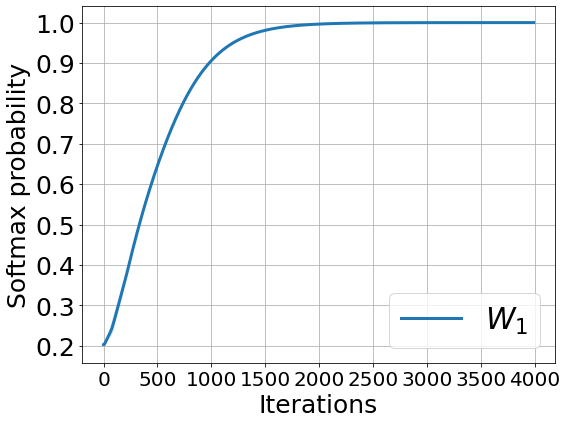

In [15]:
# set idx=0 for W-parametrization
plt.figure(figsize=(8,6))

THRED = ITN
for ni in range(nlayer):

    THRED = ITN - 10
    mean, std = attn_probs[0, ni].mean(0)[:THRED], attn_probs[0, ni].std(0)[:THRED]

    plt.plot(attn_probs[0, ni].mean(0)[:THRED], linewidth=3, label=r'$W_{}$'.format(ni + 1))
    plt.fill_between(range(THRED), mean-std, mean+std, alpha=0.15, linewidth=0)

    plt.xlabel('Iterations', fontsize=25)
    plt.ylabel('Softmax probability', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=25)
plt.grid()
plt.legend(fontsize=30)
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))

THRED = ITN - 10
for ni in range(nlayer):
    plt.plot(1 - (attn_probs[0, ni].mean(0)[:THRED]), label = r"$W_{}$".format(ni + 1), linewidth=3)

    # plt.xticks(range(0, THRED, 1000), fontsize=25)
    # plt.yticks([], fontsize=25)
    plt.yscale("log")
    plt.xticks([i for i in range(0, THRED, 500)], fontsize=20)
    plt.xlim([-10, THRED])

    plt.xlabel(r'Iterations (lr: {})'.format(lr), fontsize=20)
    plt.ylabel(r'1 - Attn', fontsize=30)
plt.legend(fontsize=30)

plt.grid()
plt.tight_layout()
plt.show()